In [1]:
import geopandas as geopd
import pandas as pd
import hvplot.pandas
import rasterio
#from rasterio.plot import show


import numpy as np

from whitebox.WBT.whitebox_tools import WhiteboxTools


import shapely
from shapely import Point, LineString, MultiLineString


from graph_utils import *

#from momepy import close_gaps

import os

from tqdm.notebook import tqdm

#import leafmap.leafmap as leafmap

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [2]:
vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

src_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/network.gpkg"

dst_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/modified_network.gpkg"

stream_poly_path = "/home/iiro/Documents/DIWA/data/SYKE/vesimuodostumat.gpkg"

dams_path = "/home/iiro/Documents/GIS/Maanmittauslaitoksen data/mml/maastotietokanta/2023/gpkg/MTK-muut_23-03-02.gpkg"

tmp_node_dir = "/tmp/stream_networks" 

tmp_node_path = os.path.join(tmp_node_dir, "nodes.shp")

tmp_snap_path = os.path.join(tmp_node_dir, "nodes.shp")

raster_root = "/media/iiro/T9/gisT7/korkeusmalli_10_m"

stream_dir = os.path.join(raster_root, "stream_thresholding")
d8_dir = os.path.join(raster_root, "d8_pointer")

if not os.path.isdir(tmp_node_dir):
    os.makedirs(tmp_node_dir)

tolerance = 0.1

max_seg_length = 500

### TODO 
- clip network with lakes
- clip network with dams
    - each dam becomes a node 
- check network topology
- create new nodes based on the network
- Get the stream length of each network section
- calculate total length to pour and lake path length downstream
- count the amount of dams downstream
    - move the information to the node that is upstream from the network section

- join knowledge of basin id and other useful info to nodes
- Snap the nodes to the raster stream network 
- Calculate subwatersheds
- Vectorize subwatersheds
- 
- Create a simplified network from just the nodes for visualization


In [6]:
test_selection = 30

wbt = WhiteboxTools()
wbt.set_verbose_mode(False)

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    if i < test_selection:
        continue
    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])
    
    #boundary = watershed.boundary.explode().reset_index()
    
    bounds = watershed.bounds
    minx = bounds.at[0, 'minx']
    miny = bounds.at[0, 'miny']
    maxx = bounds.at[0, 'maxx']
    maxy = bounds.at[0, 'maxy']
    
    # Getting the gauge that corresponds to the watershed
    place_id = watershed.at[0, 'Paikka_Id']

    # Reading the previously created layers
    orig_pour = geopd.read_file(src_path, layer=f"pour_{place_id}") 
    orig_nodes = geopd.read_file(src_path, layer=f"nodes_{place_id}")
    network = geopd.read_file(src_path, layer=f"network_{place_id}")
    # At least one river (1248) has duplicated geometry, which makes things work wierd
    network = network[network.duplicated("geometry")]
    orig_network = network.copy()
    columns_to_keep = ['objectid', 'geometry']
    network = network[columns_to_keep]
    original_network = network.copy()
    
    stream_poly = geopd.read_file(stream_poly_path, bbox=(minx, miny, maxx, maxy))
    columns_to_keep = ['tyyppi', 'geometry']
    stream_poly = stream_poly[columns_to_keep]
    lakes = stream_poly[stream_poly['tyyppi']=='Allas']
    # Buffering the lakes a bit to remove edge effects (removes some very short vertices)
    
    lakes.loc[:, 'geometry'] = lakes['geometry'].buffer(20)
    lakes = geopd.overlay(lakes, watershed, how='intersection', keep_geom_type=True)

    dams = geopd.read_file(dams_path, layer="pato", bbox=(minx, miny, maxx, maxy))
    # Z-coordinate is not needed and may cause weird interactions
    dams['geometry'] = dams.geometry.apply(drop_z_coordinates)
    
    # Multiline geometries are changed into multiple linestrings
    network = network.explode(ignore_index=True)

    # clipping with dams is done before lake division so that hassle of moving attributes can be skipped
    network_dam_is_points = network.overlay(dams, how='intersection', keep_geom_type=False)
    network_dam_is_points = network_dam_is_points.drop_duplicates().reset_index(drop=True)

    network = slice_linestrings(network, dams)
    """
    # Clipping network with  lakes
    intersection = network.overlay(lakes, 'intersection')
    difference = network.overlay(intersection, 'difference')
    
    network = pd.concat([intersection, difference])
    network.loc[:,'tyyppi'] = network['tyyppi'].fillna('Uoma')
    """
    
    # If there are too long vertices, they are subdivided
    network['geometry'] = network['geometry'].segmentize(max_segment_length=max_seg_length/2)

    network = network.explode(ignore_index=True)
    
    # The line subdivision needs some additional attributes to work properly (any column is enough)
    # The function should probably be fixed at some point to wor
    # subdividing the lines
    network = subdivide_lines(network, max_seg_length)

    network['pituus_m'] = network.length

    potential_nodes = get_start_and_end_nodes(network)
    potential_pour = get_pour(potential_nodes, tolerance=tolerance)
    potential_pour = potential_pour.assign(distance=lambda row: row.distance(orig_pour.at[0, 'geometry']))
    potential_pour = potential_pour.loc[potential_pour['distance'] < tolerance]

    # If the tolerance is too large, very small sections near pour point will cause problems
    assert len(potential_pour) != 0, f"Gauge {place_id} is too far from closest pour"
    

    #print(f"Pour {place_id} after boundary clipping {len(pour)}")
    #print("-" * 10)

    # The network is traversed in order to determine the correct pour point and sufficient netowrk coverage
    long_visited = []
    potential_pours = []
    long_nodes = []
    for j, pour_j in potential_pour.iterrows():
        # Changing from 
        pour_j = geopd.GeoDataFrame(
            dict(zip(list(pour_j.index), list(pour_j.values))),
            crs=orig_pour.crs, geometry='geometry', index=[0])
        
        pour_j_connections = add_connections(potential_nodes, pour_j)
        #print(len(pour_j_connections))
        visited = traverse_graph(pour_j_connections, pour_j.at[0, 'id'])
        
        
        # small offshoot branches are skipped, Pesiö's watersheds are special becuse they are so tiny
        pesiö_ids = ['2641', '2643', '2646']
        
        if len(visited) > 2 or place_id in pesiö_ids:
            coverage = round((len(visited) / len(pour_j_connections) *100), 1)
            if coverage < 95:
                print(f"{coverage} % of nodes visited for gauge {place_id}")    
            long_visited.append(visited)
            potential_pours.append(pour_j)
            long_nodes.append(pour_j_connections)
            if len(long_visited) > 1:
                print("multiple pour points remain with long networks")
    
    pour = potential_pours[0]

    pour_idx = pour.at[0, 'id']

    
    
    # Getting the nodes that are not on the short side branches
    nodes = long_nodes[0]

    
    #pd.options.mode.chained_assignment = None  # default='warn'
    nodes.loc[:, 'pour'] = nodes.id == pour_idx
    # Setting pour to self loop
    
    nodes['dam'] = nodes['geometry'].intersects(network_dam_is_points.buffer(10).union_all())
    
    # pd.options.mode.chained_assignment = 'warn'  # default='warn'
    before_dam_clipping = nodes.copy()
    
    # Fixing very short sections that arise from dam clipping
    nodes = correct_dam_slivers(nodes, 10)

    #after_dam_clipping = nodes.copy()
    # Next node type is changed to int, there shouldn't be nan's at this point
    nodes['next'] = nodes['next'].astype(int)
    
    
    
    nodes = merge_short_segments(nodes, max_seg_length)

    # counting the in-connectedness to differentiate intersections from other types
    nodes = in_connectedness(nodes)

    nodes['lake'] = nodes.intersects(lakes.geometry.union_all())

    # Whiteboxtools requires shapefiles, which destroys shorter column names thus it is important to join 
    nodes.to_file(tmp_node_path)

    stream_path = os.path.join(stream_dir, f"stream_thresholding_{watershed.at[0, 'main_basin_index']}.tif")
    d8_path = os.path.join(d8_dir, f"d8_pointer_{watershed.at[0, 'main_basin_index']}.tif")
    dst_dir = os.path.join(raster_root, "watershed", watershed.at[0, 'Paikka_Id'], "sub")
    
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)

    subwatershed_path = os.path.join(dst_dir, f"watershed_{watershed.at[0, 'Paikka_Id']}.tif")

    wbt.jenson_snap_pour_points(tmp_node_path, stream_path, tmp_snap_path, 100)

            # Watershed calculation
    wbt.watershed(d8_path, tmp_snap_path, subwatershed_path)
    
    """
    –––––
    Tests
    –––––
    """

    # Checking that the node topology is intact
    result = check_node_network_topology(nodes)
    
    for key in result:
        if not result[key]:
            print(f"network {watershed.at[0, "Paikka_Id"]} has problems with {key}")

    # Checking that the lengths dont change much 
    length_difference = network.pituus_m.sum() - nodes.pituus_m.sum()
    if length_difference > 10:
        print(f"{place_id}: difference of lenght of {length_difference}m for nodes and network")

    
    nodes.to_file(dst_path, layer=f"nodes_{place_id}", driver="GPKG")
    
    if i == test_selection:
        break

  0%|          | 0/142 [00:00<?, ?it/s]

(239416.0, 279324.0, 6704071.5, 6763658.5)

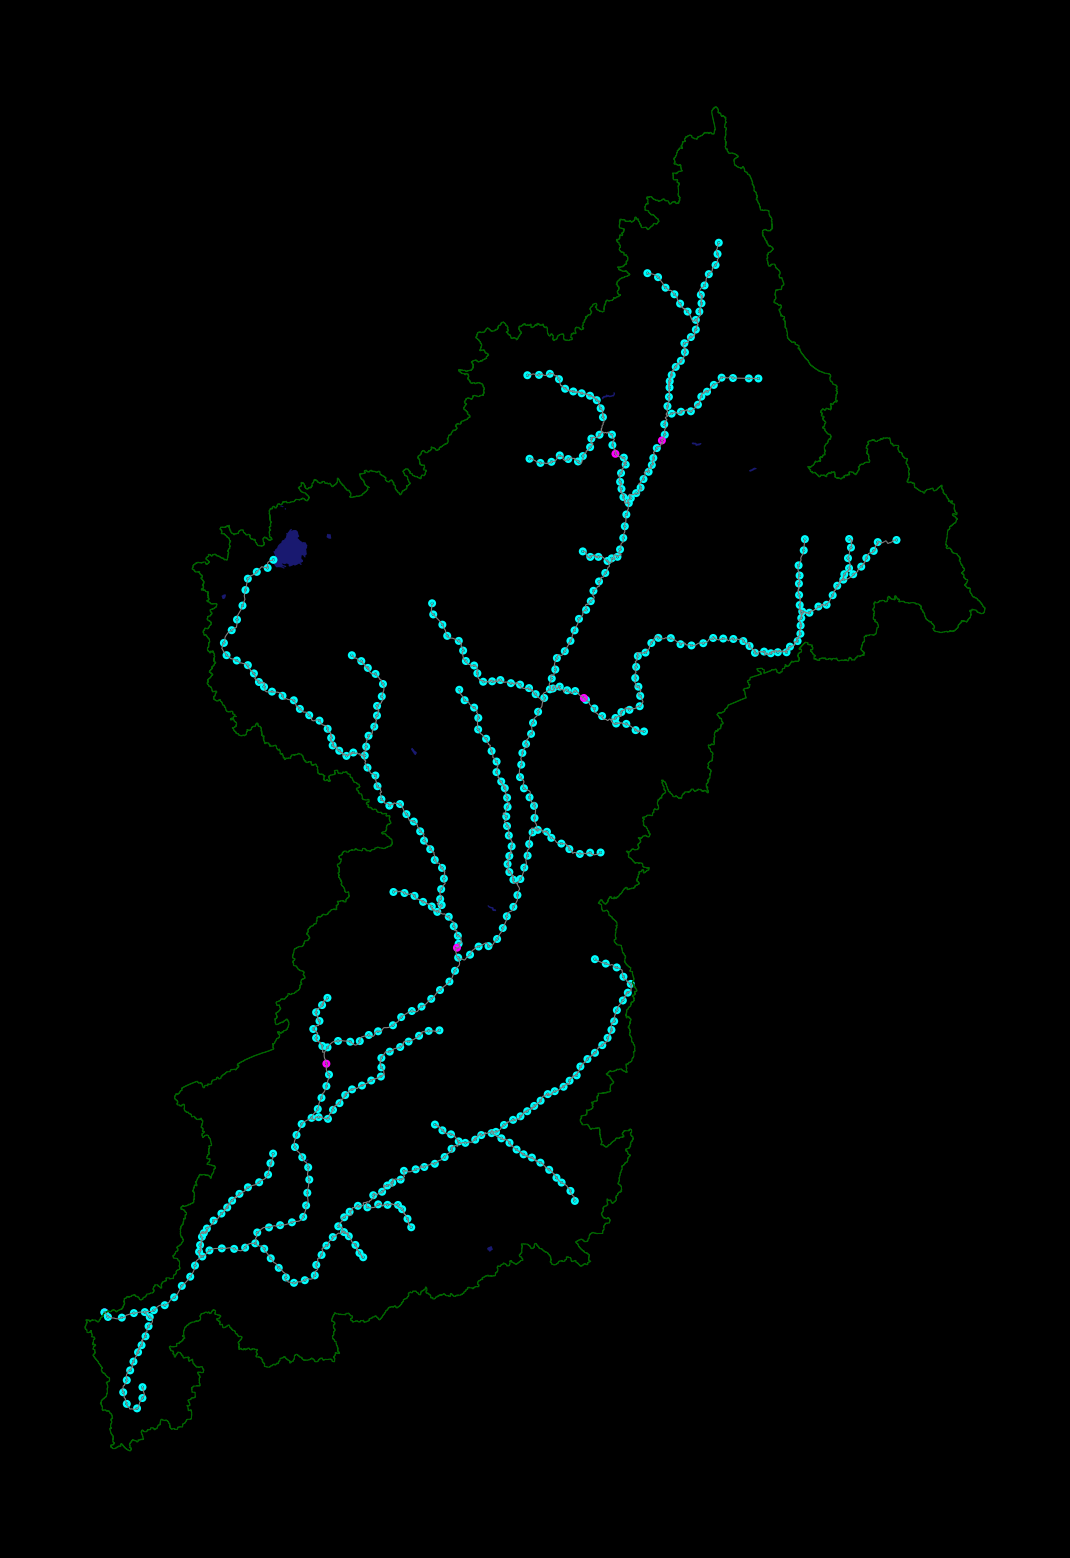

In [38]:
ax = watershed.boundary.plot(color='darkgreen', linewidth=0.2)
ax = lakes.plot(ax=ax, color='midnightblue')
#ax = boundary.plot(ax=ax, color='white', linewidth=0.1)
#ax = network.plot("tyyppi", cmap="cool", ax=ax, linewidth=0.2)
ax = network.plot(color='grey', ax=ax, linewidth=0.2)
#ax = test.plot(ax=ax, markersize=0.2, color='aqua')
#ax = orig_nodes.plot(ax=ax, markersize=0.2, color='aqua')
ax = nodes.plot('dam', ax=ax, markersize=0.2, cmap="cool")
#ax = test.plot('dam', ax=ax, markersize=0.2, cmap="viridis")
#ax = sources.plot(ax=ax, markersize=0.2, color='lime')
#ax= orig_pour.plot(color='coral', ax=ax, markersize=0.3)
#ax = pour.plot(color='coral', ax=ax, markersize=0.3)
#ax = suspects.plot(color='pink', ax=ax, markersize=0.6)
#ax = network_dam_is_points.plot(ax=ax)
#ax = dams.plot(ax=ax, color='red', linewidth=2)
#ax.set_xlim([network.total_bounds[0] -1000, network.total_bounds[2]-20000])
#ax.set_ylim([dams.total_bounds[1], dams.total_bounds[3]-23000])
plt.axis('off')

In [5]:
watershed

,Paikka_Id,main_basin_index,geometry
0,1117,15,"MULTIPOLYGON (((245240 6720480, 245240 6720470..."


<Axes: >

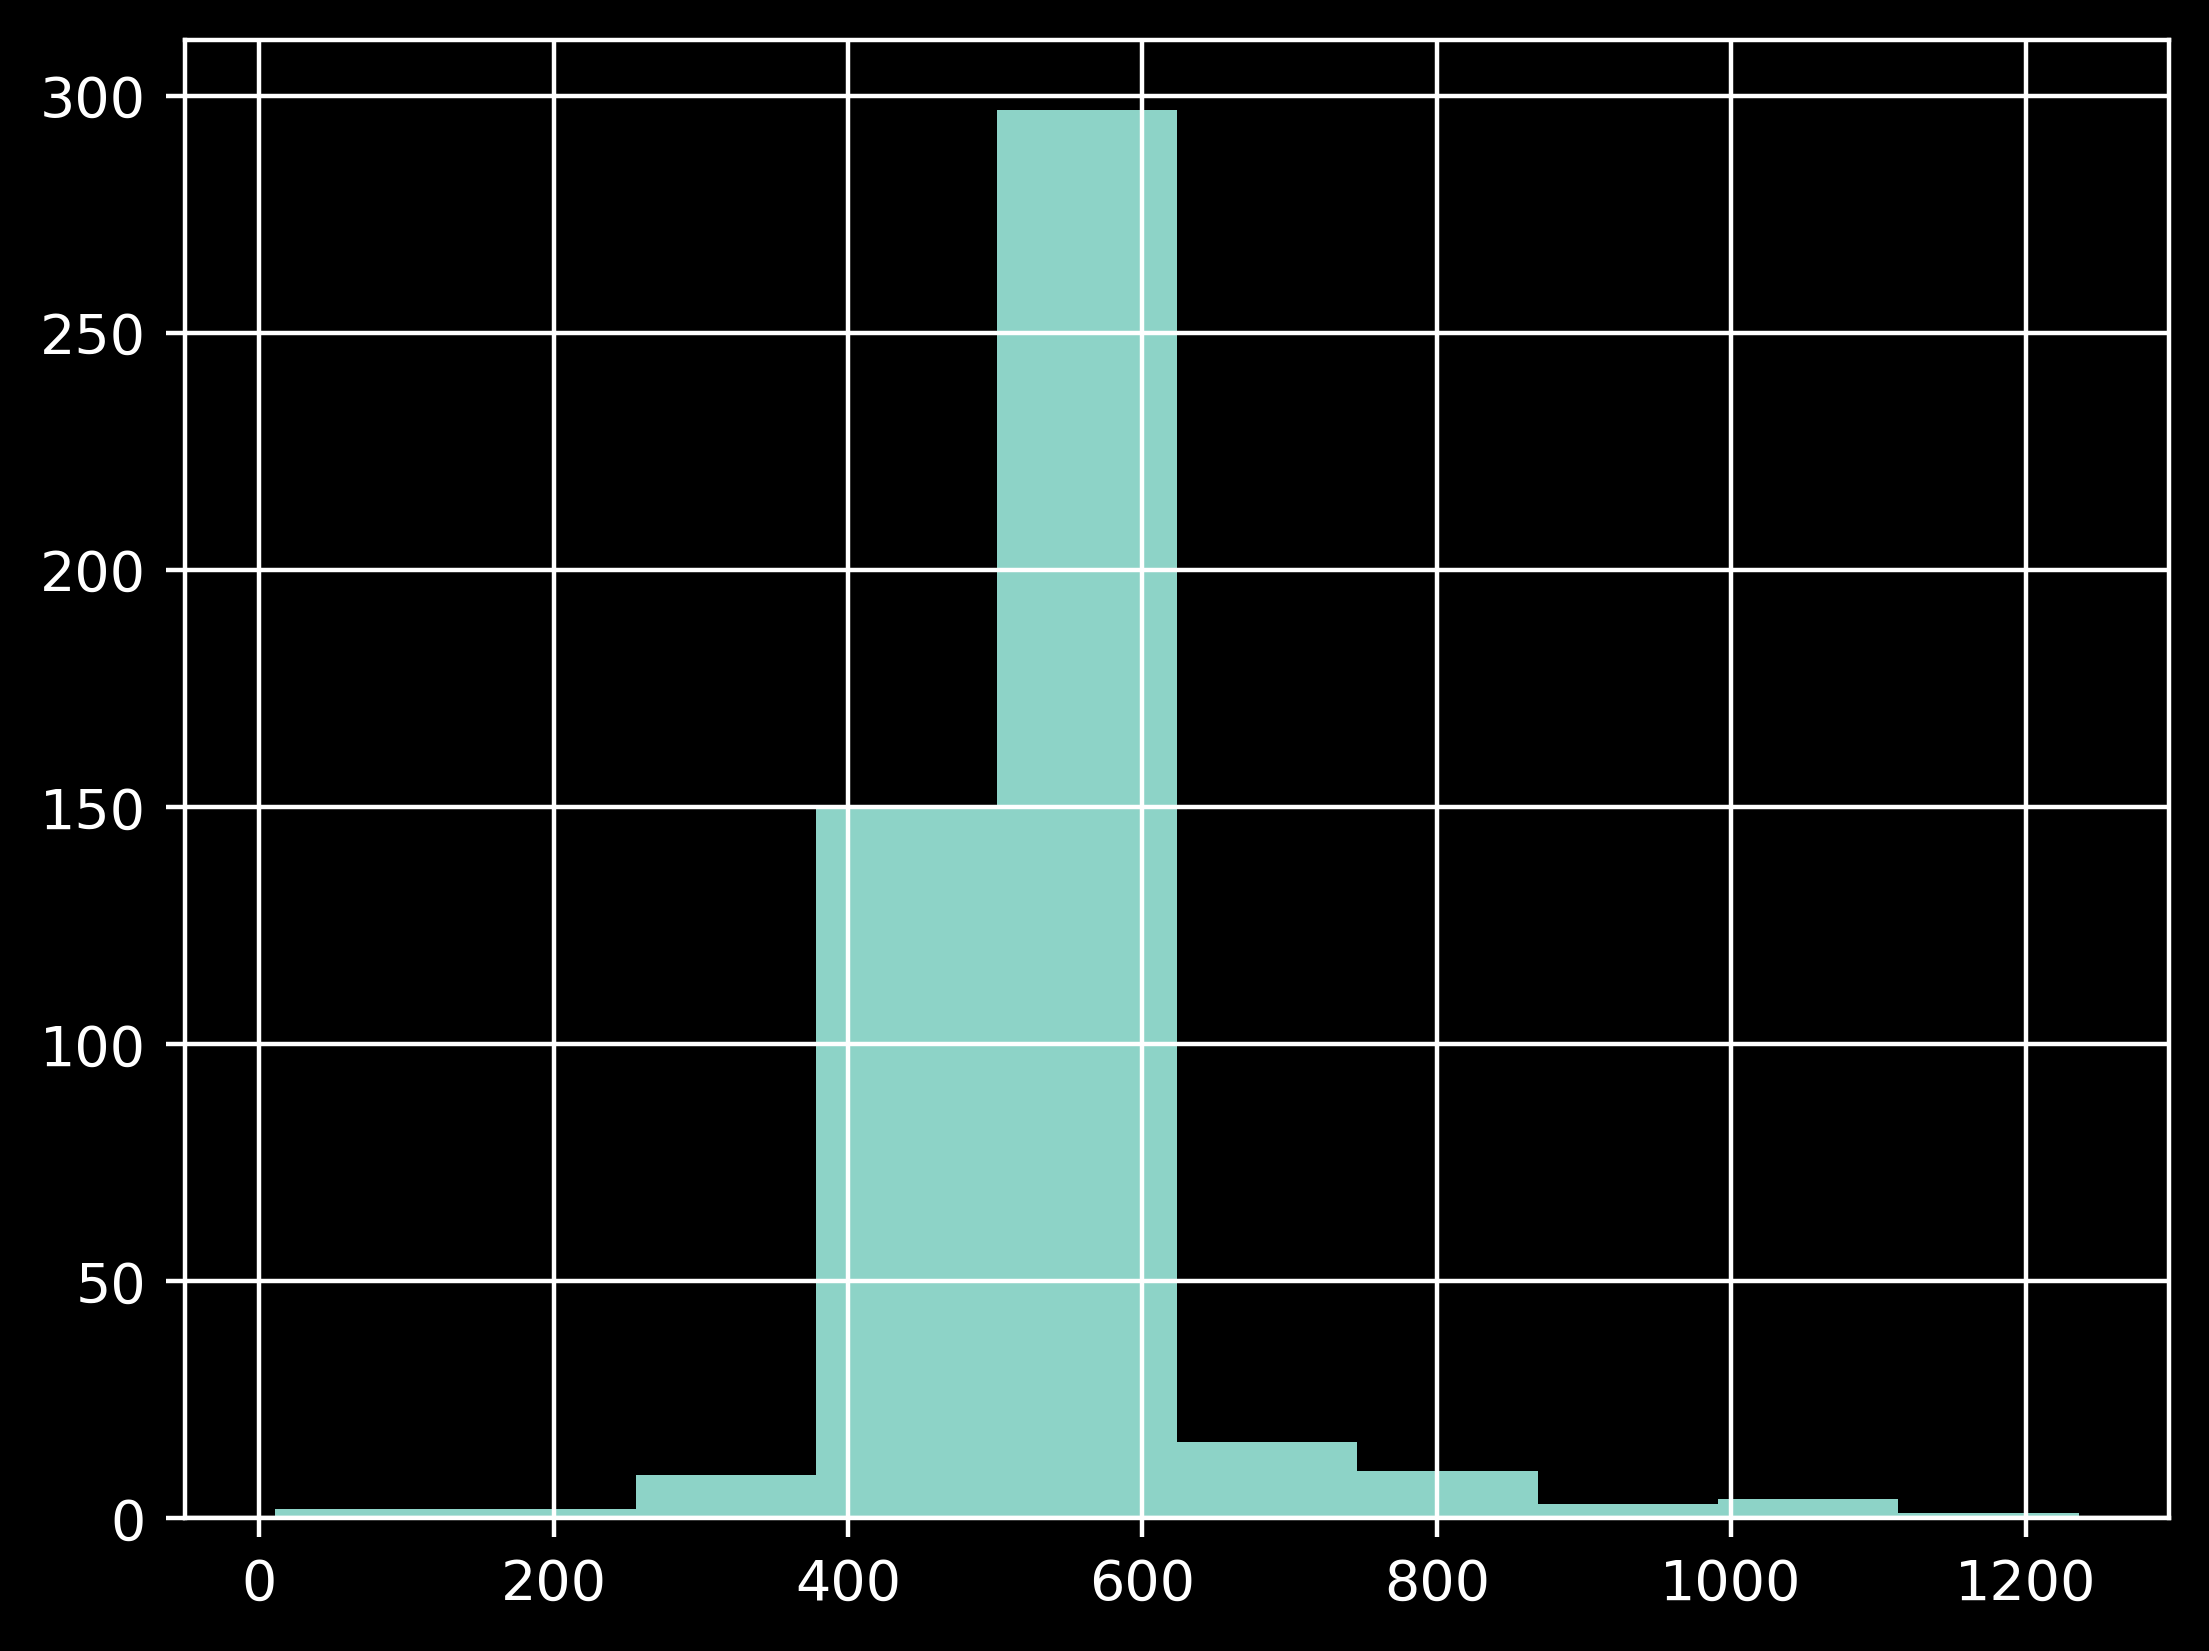

In [4]:
nodes['pituus_m'].hist()

In [12]:
sources = nodes[nodes['in_connectedness'] == 0]

<Axes: >

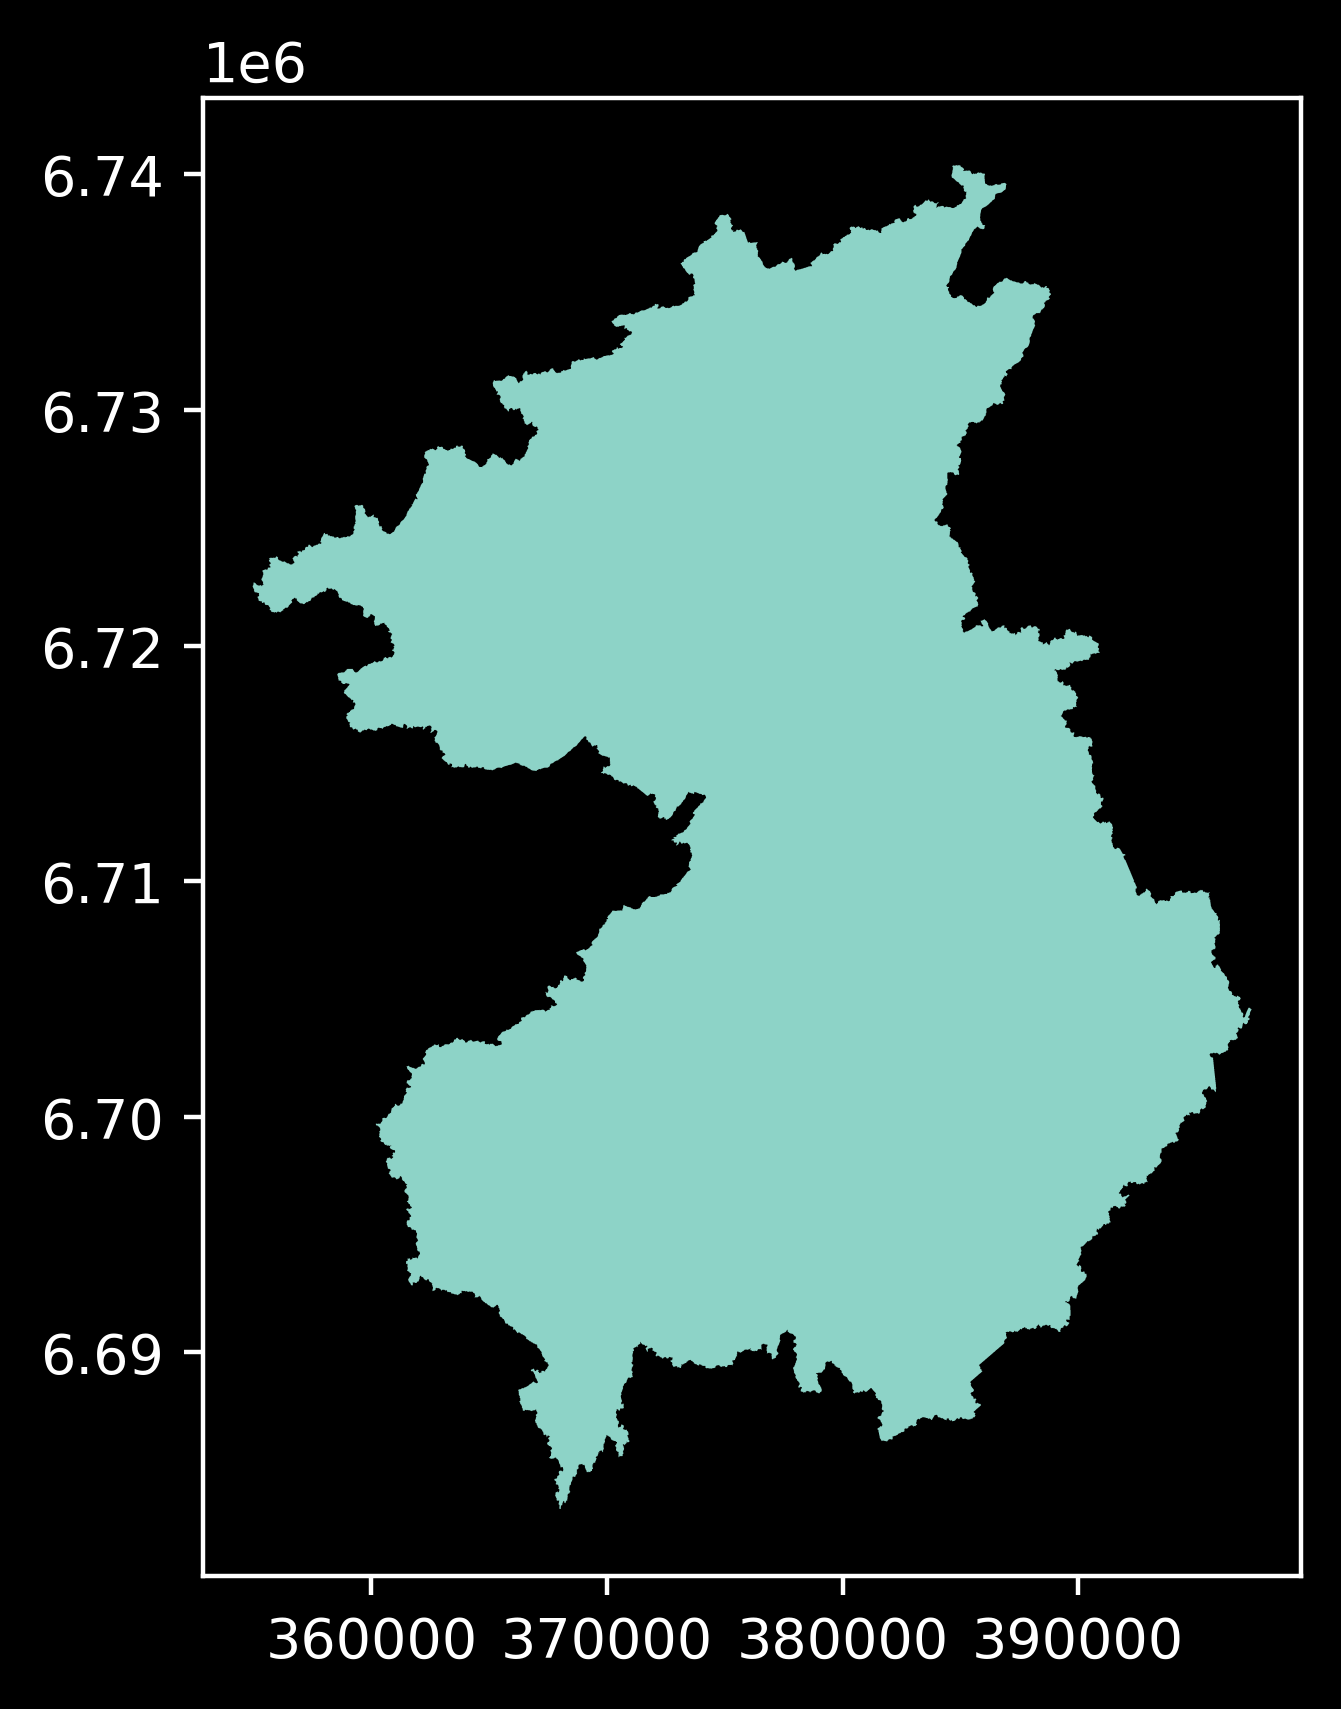

In [29]:
watersheds.loc[[17]].plot()

In [41]:
base_gdf=network.copy()

slicer = dams['geometry'].union_all()

sliced_segments = []

# Ensure both GeoDataFrames are in the same CRS
#if base_gdf.crs != cutter_gdf.crs:
    #cutter_gdf = cutter_gdf.to_crs(base_gdf.crs)

for line in base_gdf.geometry:
    #if not isinstance(line, LineString) or not isinstance(line, MultiLineString):
        #raise ValueError("All geometries in base_gdf must be LineStrings.")

    splitted = split(line, slicer)
    split_result = list(splitted.geoms)
            
    sliced_segments.extend(split_result)
    
sliced = geopd.GeoDataFrame({"geometry":sliced_segments}, geometry="geometry", crs=base_gdf.crs)
        

In [4]:
lines_1 = [LineString([(0, 0), (2,2)]), LineString([(0, 5), (5,5)])]
lines_2 = [LineString([(-1, 1), (3,1)])]

gdf_1 = geopd.GeoDataFrame({"geometry":lines_1}, crs="EPSG:3067", geometry="geometry")
gdf_2 = geopd.GeoDataFrame({"geometry":lines_2}, crs="EPSG:3067", geometry="geometry")

test_result = slice_linestrings(gdf_1, gdf_2)

In [146]:
print(LineString(dams.at[0, 'geometry']))

LINESTRING Z (598599.068 7002268.147 167.3, 598597.071 7002268.145 -999.999, 598595.632 7002267.575 168.348, 598594.769 7002266.415 167.3)


In [143]:
network.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [67]:
place_id

'3538'